In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
from astropy.table import Table
from desitarget.targetmask import desi_mask
import os 
%matplotlib inline

In [2]:
datapath = "/global/cscratch1/sd/forero/testfiber/dark_large/fiber_output/"
tiles = glob.glob(datapath+"*.fits")
print('Total numer of tiles:', len(tiles))

Total numer of tiles: 7098


In [3]:
def count_targets(tilefile):
    
    tileid = int(tilefile.split('_')[-1].split('.')[0])
    
    # mask for sky targets
    sky_mask = desi_mask.SKY
    
    # mask for stdstar targets
    std_mask = 0
    for name in ['STD', 'STD_FSTAR', 'STD_WD',
             'STD_FAINT', 'STD_FAINT_BEST',
             'STD_BRIGHT', 'STD_BRIGHT_BEST']:
        if name in desi_mask.names():
            std_mask |= desi_mask[name]

    # This is the field with the assignments
    assigned = Table.read(tilefile, 'FIBERASSIGN')
    
    # This is the field with the potential assigments
    potential = Table.read(tilefile, 'POTENTIAL')

    # Unassigned fibers have TARGETID==-1
    nassigned = len(assigned)-np.count_nonzero(assigned['TARGETID']==-1)
    
    # find whether a sky or stdstar target has been assigned
    nstd = np.count_nonzero(assigned['DESI_TARGET'] & std_mask)
    nsky = np.count_nonzero(assigned['DESI_TARGET'] & sky_mask)
    npotential = len(potential)

    # the number of science targets assigned
    nscience = nassigned - nstd - nsky
    
    
    return {'tileid':tileid,
            'RA':np.median(assigned['TARGET_RA']),
            'DEC':np.median(assigned['TARGET_DEC']),
            'npotential':npotential, 'nscience':nscience, 'nstd':nstd, 'nsky':nsky}

In [4]:
if not os.path.isfile('tile_counts.txt'):
    n_tiles = len(tiles)
    count_all = {}
    for i in range(n_tiles):
        count_all[i] = count_targets(tiles[i])
        if not(i % (n_tiles//100)):
            print("{:}%  ".format(int(100.0*i/n_tiles)), end="\b")

In [5]:
def write_counts(count_all, outfile = 'tile_counts.txt'):
    f  = open(outfile, 'w')
    f.write("# TILEID RA DEC NSKY NSTD NSCIENCE NPOTENTIAL\n")
    n_tiles = len(count_all)
    for i in range(n_tiles):
        f.write("{:d}\t".format(count_all[i]['tileid']))
        f.write("{:.2f}\t".format(count_all[i]['RA']))
        f.write("{:.2f}\t".format(count_all[i]['DEC']))
        f.write("{:d}\t".format(count_all[i]['nsky']))
        f.write("{:d}\t".format(count_all[i]['nstd']))
        f.write("{:d}\t".format(count_all[i]['nscience']))
        f.write("{:d}\t".format(count_all[i]['npotential']))
        f.write("\n")
    f.close()

In [6]:
if not os.path.isfile('tile_counts.txt'):
    write_counts(count_all)

In [26]:
counts = Table.read('tile_counts.txt', format='ascii')
counts['NUSED'] = counts['NSKY'] + counts['NSTD'] + counts['NSCIENCE']

In [53]:
def plot_footprint(counts, field = 'SCIENCE', limit=5000, threshold='above'):
    c = counts['N'+field]

    plt.figure(figsize=(10,6))
    plt.rc('text', usetex=False,)
    plt.rc('font', family='serif', size=18)
    if threshold=='above':
        ii = c > limit
        title = '# of tiles with more than {} {} fibers: {}'.format(limit, field.lower(), np.count_nonzero(ii))
    elif threshold=='below':
        ii = c < limit
        title = '# of tiles with less than {} {} fibers: {}'.format(limit, field.lower(), np.count_nonzero(ii))
    elif threshold=='exact':
        ii = c == limit
        title = '# of tiles with exactly {} {} fibers: {}'.format(limit, field.lower(), np.count_nonzero(ii))
    elif threshold == 'all':
        ii = np.arange(len(c))
        title = '# of tiles : {}'.format(len(ii))

            
    plt.scatter(counts['RA'][ii], counts['DEC'][ii], c=c[ii], alpha=0.5)
    plt.xlabel('RA [deg]')
    plt.ylabel('DEC [deg]')
    
    label =  " {} fibers per tile".format(field.lower())
    plotname = 'doc/assigned_{}_ra_dec_{}.pdf'.format(field.lower(), threshold)
    
    plt.colorbar(label = label)
    plt.title(title)
    plt.savefig(plotname, bbox_inches='tight')

In [129]:
def plot_single_tile(tilefile):
    tileid = int(tilefile.split('_')[-1].split('.')[0])
    
    plt.figure(figsize=(15,14))
    plt.rc('text', usetex=False,)
    plt.rc('font', family='serif', size=15)

    assigned = Table.read(tilefile, 'FIBERASSIGN')
    gfa = Table.read(tilefile, 'GFA')
    skyetc = Table.read(tilefile, 'SKYETC')

    # mask for sky targets
    sky_mask = desi_mask.SKY
        
    # mask for stdstar targets
    std_mask = 0
    for name in ['STD', 'STD_FSTAR', 'STD_WD',
             'STD_FAINT', 'STD_FAINT_BEST',
             'STD_BRIGHT', 'STD_BRIGHT_BEST']:
        if name in desi_mask.names():
            std_mask |= desi_mask[name]

    # find whether a sky or stdstar target has been assigned
    ii_sky = (assigned['DESI_TARGET'] & sky_mask)!=0
    ii_std = (assigned['DESI_TARGET'] & std_mask)!=0

    
    # min max
    minra = assigned['TARGET_RA'].min()
    maxra = assigned['TARGET_RA'].max()
    mindec = assigned['TARGET_DEC'].min()
    maxdec = assigned['TARGET_DEC'].max()
    
    plt.subplot(2,2,1)
    plt.scatter(assigned['TARGET_RA'][ii_sky], assigned['TARGET_DEC'][ii_sky], s=1.0, label='{} SKY fibers'.format(np.count_nonzero(ii_sky)))
    plt.legend()
    plt.xlabel('RA [deg]')
    plt.ylabel('DEC [deg]')
    plt.xlim([minra, maxra])
    plt.ylim([mindec, maxdec])

    plt.subplot(2,2,2)
    plt.scatter(assigned['TARGET_RA'][ii_std], assigned['TARGET_DEC'][ii_std], s=10.0, label='{} STD fibers'.format(np.count_nonzero(ii_std)))
    plt.legend()
    plt.xlabel('RA [deg]')
    plt.ylabel('DEC [deg]')
    plt.xlim([minra, maxra])
    plt.ylim([mindec, maxdec])

    ii = skyetc['TARGETID']>0
    plt.subplot(2,2,3)
    plt.scatter(gfa['RA'], gfa['DEC'], s=10.0, label='GFA')
    plt.scatter(skyetc['RA'][ii], skyetc['DEC'][ii], s=10.0, label='SKYETC')
    plt.xlabel('RA [deg]')
    plt.ylabel('DEC [deg]')
    plt.xlim([minra, maxra])
    plt.ylim([mindec, maxdec])
    plt.legend()

    plt.subplot(2,2,4)
    ii_science = (assigned['TARGETID'] > 0) & (~(ii_sky|ii_std) )
    print(np.count_nonzero(ii_science))
    plt.scatter(assigned['TARGET_RA'][ii_science], assigned['TARGET_DEC'][ii_science], s=1.0, label='{} SCIENCE fibers'.format(np.count_nonzero(ii_science)))
    plt.legend()
    plt.xlabel('RA [deg]')
    plt.ylabel('DEC [deg]')
    plt.xlim([minra, maxra])
    plt.ylim([mindec, maxdec])
    plt.savefig('doc/single_tile_{}.pdf'.format(tileid), bbox_inches='tight')

TILEID   RA    DEC   NSKY NSTD NSCIENCE NPOTENTIAL NUSED
------ ------ ------ ---- ---- -------- ---------- -----
  4286  56.46 -10.59  185  100     4715      43833  5000
  6241 311.42  -6.12  150   92     4758      38514  5000
[ '/global/cscratch1/sd/forero/testfiber/dark_large/fiber_output/tile_04286.fits'
 '/global/cscratch1/sd/forero/testfiber/dark_large/fiber_output/tile_06241.fits']
4715
4758


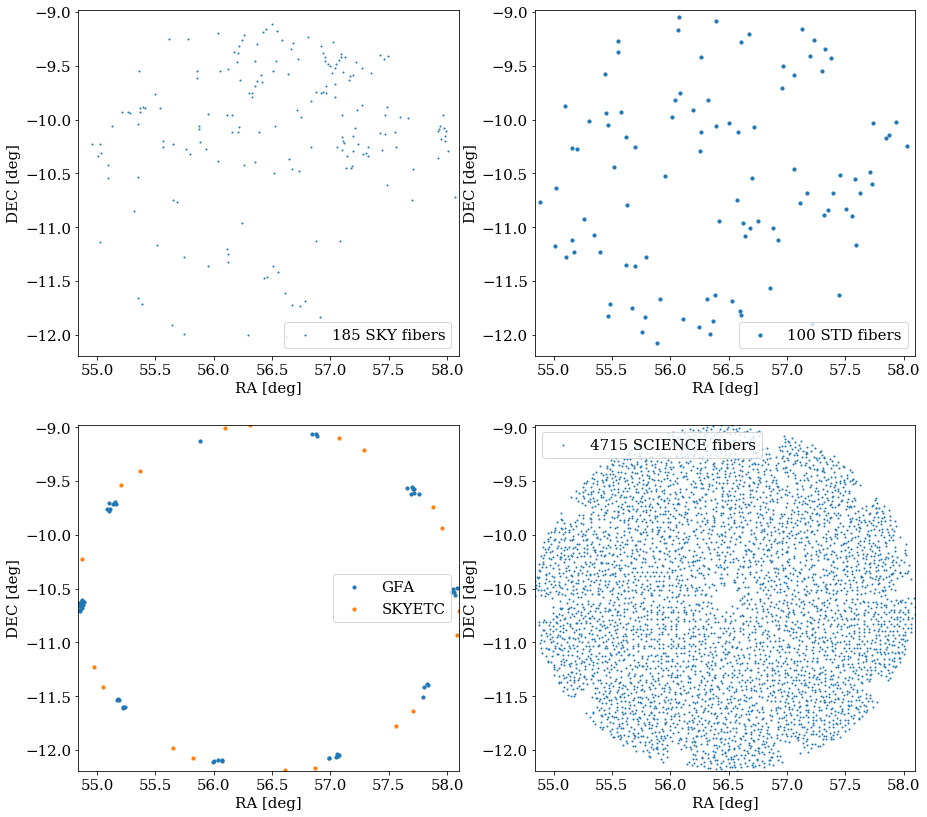

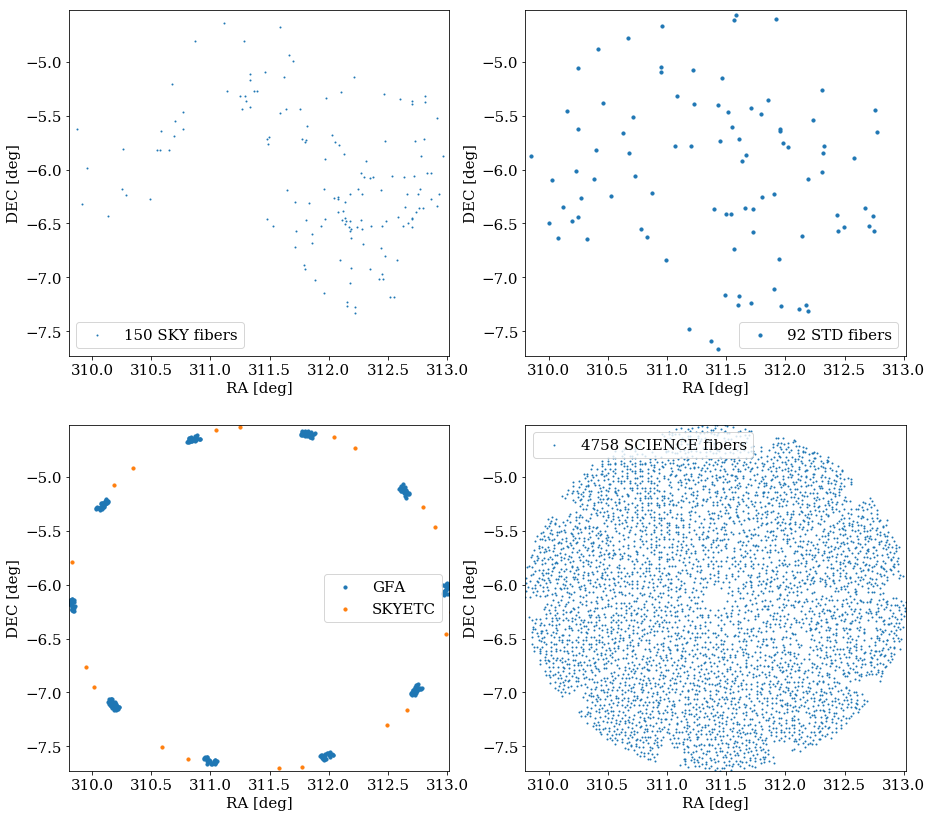

In [130]:
ii = (counts['NSKY'] < 200) & (counts['NSCIENCE']>4500) & (counts['NUSED']==5000)
print(counts[ii])
print(np.array(tiles)[ii])

plot_single_tile(np.array(tiles)[ii][0])
plot_single_tile(np.array(tiles)[ii][1])

TILEID   RA    DEC  NSKY NSTD NSCIENCE NPOTENTIAL NUSED
------ ------ ----- ---- ---- -------- ---------- -----
  1858 120.12 34.46   42   40     2409      13105  2491
  6854   4.59 30.67    1   16     2477      10098  2494
[ '/global/cscratch1/sd/forero/testfiber/dark_large/fiber_output/tile_01858.fits'
 '/global/cscratch1/sd/forero/testfiber/dark_large/fiber_output/tile_06854.fits']
2409
2477


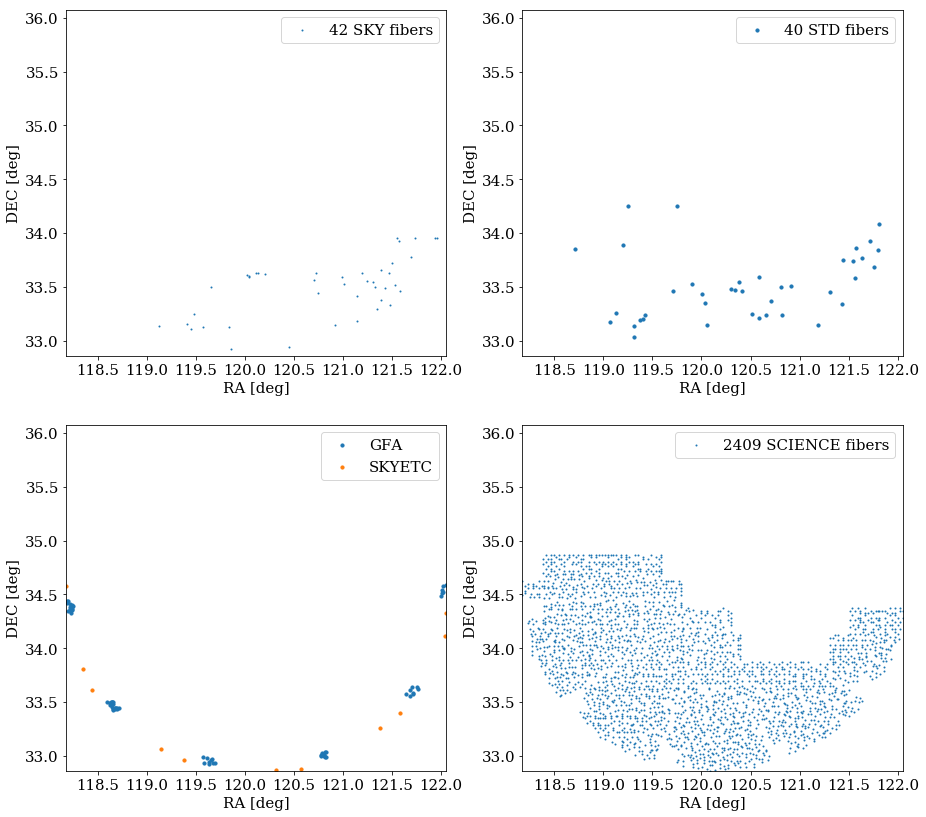

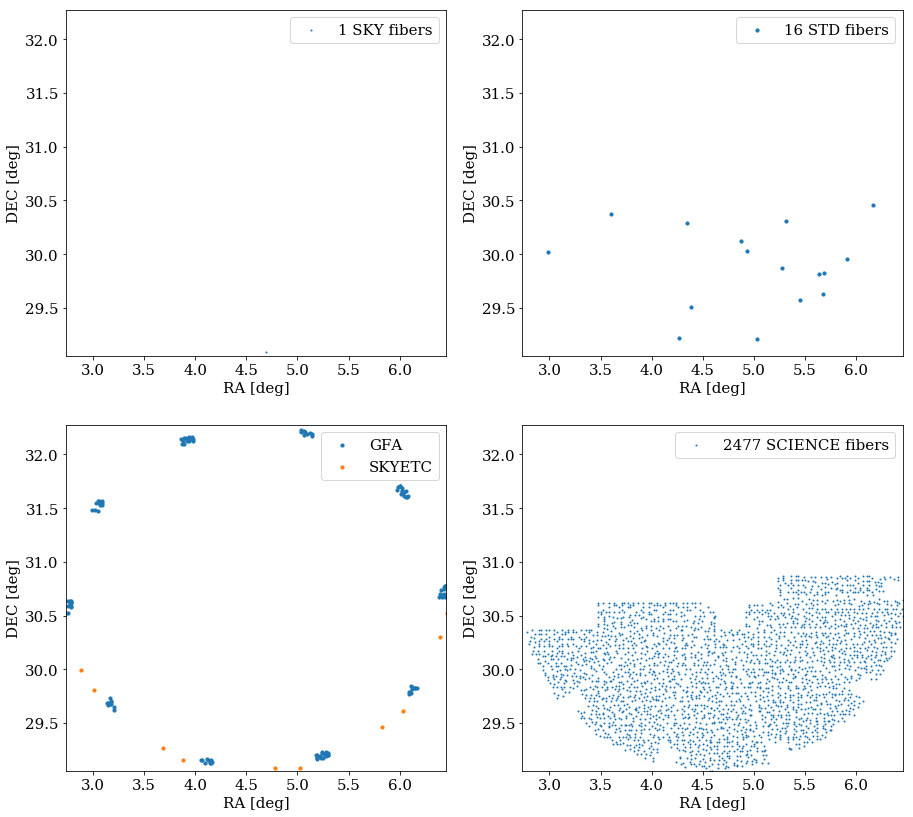

In [138]:
ii = (counts['NUSED']>2490) & (counts['NUSED']<2500)
print(counts[ii])
print(np.array(tiles)[ii])

plot_single_tile(np.array(tiles)[ii][0])
plot_single_tile(np.array(tiles)[ii][1])

TILEID   RA    DEC   NSKY NSTD NSCIENCE NPOTENTIAL NUSED
------ ------ ------ ---- ---- -------- ---------- -----
  1877   35.8   2.96  400  100     4500      49995  5000
 14270 201.89   25.2  400  100     4500      52605  5000
 11235 178.16  15.81  400  100     4500      54493  5000
  8519 199.99   5.36  400  100     4500      54478  5000
  6604 115.24   19.1  400  100     4500      50818  5000
  9656 216.35    5.9  400  100     4500      54026  5000
  7346   6.48   0.02  400  100     4500      51713  5000
  7594 123.62  26.94  400  100     4500      50518  5000
 14262  199.6   2.66  400  100     4500      53385  5000
  3775  139.9  -6.05  400  100     4500      51056  5000
   ...    ...    ...  ...  ...      ...        ...   ...
 14915 192.93  -0.05  400  100     4500      52034  5000
  1590  21.39    0.0  400  100     4500      55475  5000
 22752 178.97  13.17  400  100     4500      54528  5000
 17212 238.34  13.56  400  100     4500      52280  5000
   569  25.37  -2.71  400  100 

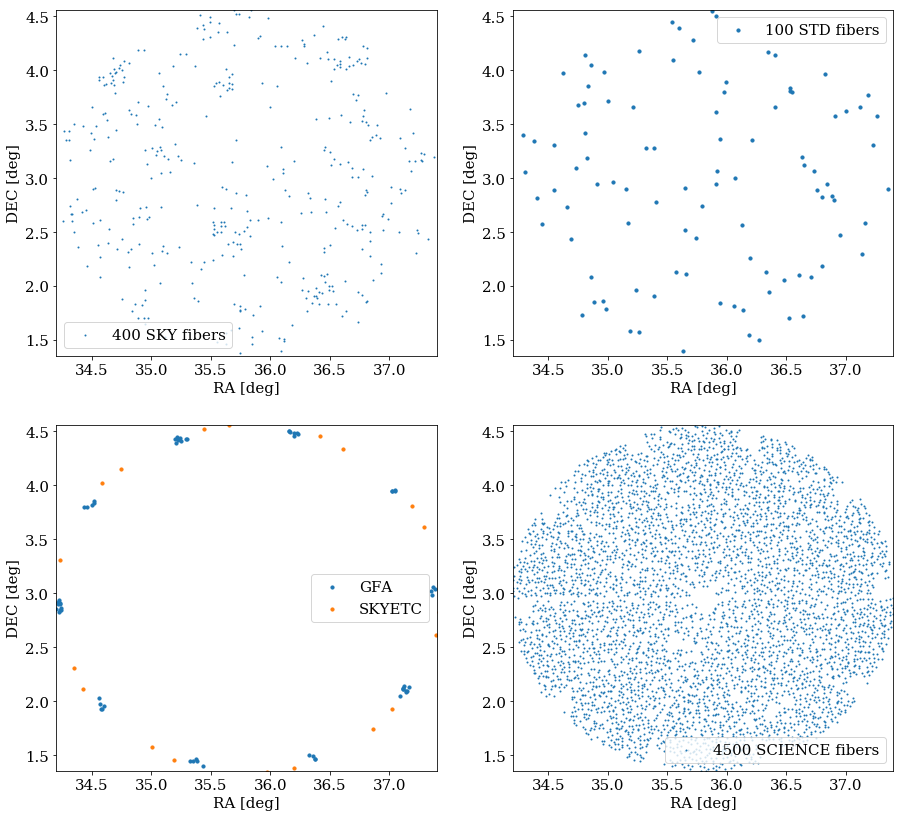

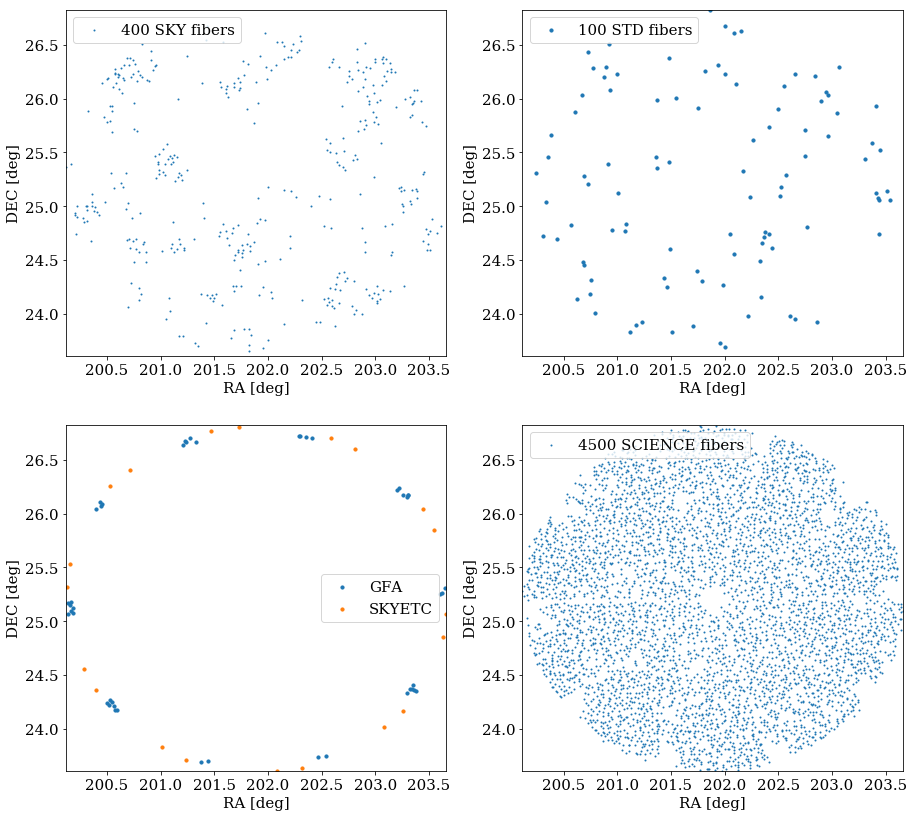

In [142]:

plot_single_tile(np.array(tiles)[ii][0])
plot_single_tile(np.array(tiles)[ii][1])

2457


Text(0,0.5,'Y [mm]')

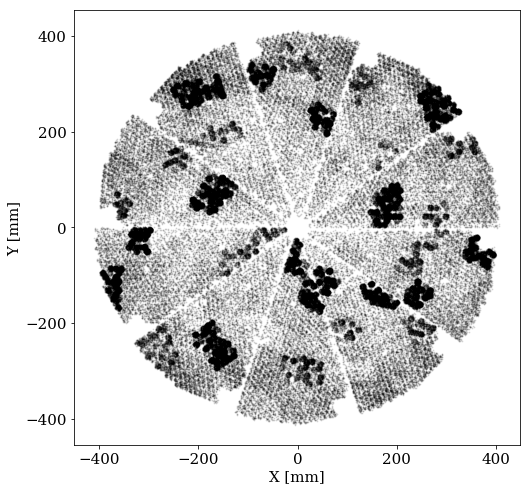

In [162]:
plt.figure(figsize=(8,8))
plt.rc('text', usetex=False,)
plt.rc('font', family='serif', size=15)
ii = (counts['NUSED']==5000) & (counts['NSCIENCE']==4500) & (counts['NSKY']==400)
print(np.count_nonzero(ii))
#print(np.array(tiles)[ii])
for tilefile in np.array(tiles)[ii][0:500]:
    assigned = Table.read(tilefile, 'FIBERASSIGN')
    # mask for sky targets
    sky_mask = desi_mask.SKY    
    ii_sky = (assigned['DESI_TARGET'] & sky_mask)!=0
    
    plt.scatter(assigned['DESIGN_X'][ii_sky], assigned['DESIGN_Y'][ii_sky], s=1.0, color='black', alpha=0.1)
plt.xlabel('X [mm]')
plt.ylabel('Y [mm]')

2457


Text(0,0.5,'Y [mm]')

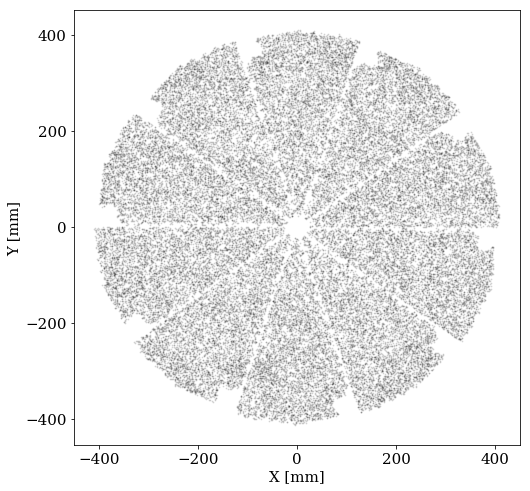

In [163]:
plt.figure(figsize=(8,8))
plt.rc('text', usetex=False,)
plt.rc('font', family='serif', size=15)
ii = (counts['NUSED']==5000) & (counts['NSCIENCE']==4500) & (counts['NSTD']==100)
print(np.count_nonzero(ii))
#print(np.array(tiles)[ii])
for tilefile in np.array(tiles)[ii][0:500]:
    assigned = Table.read(tilefile, 'FIBERASSIGN') 
    # mask for stdstar targets
    std_mask = 0
    for name in ['STD', 'STD_FSTAR', 'STD_WD',
             'STD_FAINT', 'STD_FAINT_BEST',
             'STD_BRIGHT', 'STD_BRIGHT_BEST']:
        if name in desi_mask.names():
            std_mask |= desi_mask[name]

    # find whether a sky or stdstar target has been assigned
    ii_std = (assigned['DESI_TARGET'] & std_mask)!=0
    
    plt.scatter(assigned['DESIGN_X'][ii_std], assigned['DESIGN_Y'][ii_std], s=1.0, color='black', alpha=0.1)
plt.xlabel('X [mm]')
plt.ylabel('Y [mm]')

In [ ]:
plot_footprint(counts, field='USED', limit=5000, threshold='all')
plot_footprint(counts, field='USED', limit=5000, threshold='exact')
plot_footprint(counts, field='USED', limit=5000, threshold='below')

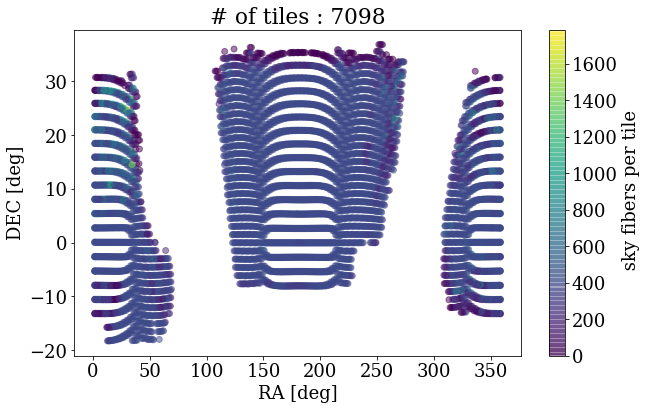

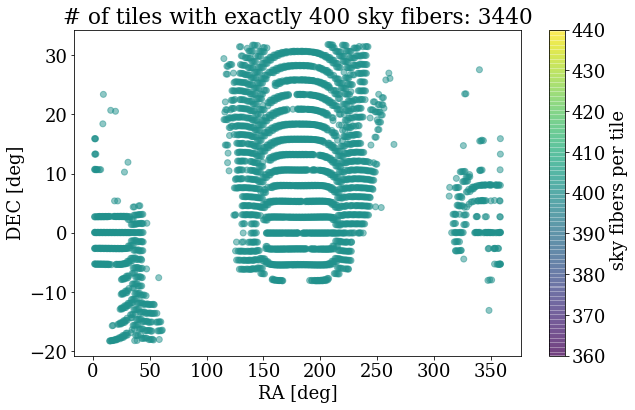

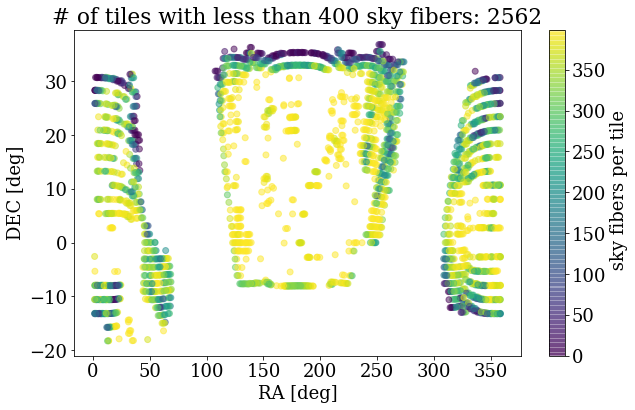

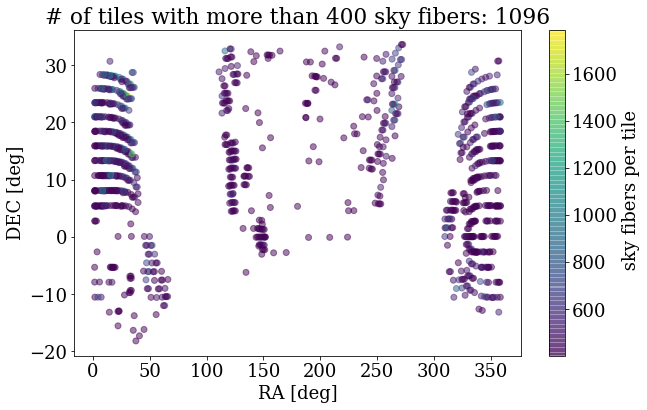

In [60]:
plot_footprint(counts, field='SKY', limit=400, threshold='all')
plot_footprint(counts, field='SKY', limit=400, threshold='exact')
plot_footprint(counts, field='SKY', limit=400, threshold='below')
plot_footprint(counts, field='SKY', limit=400, threshold='above')

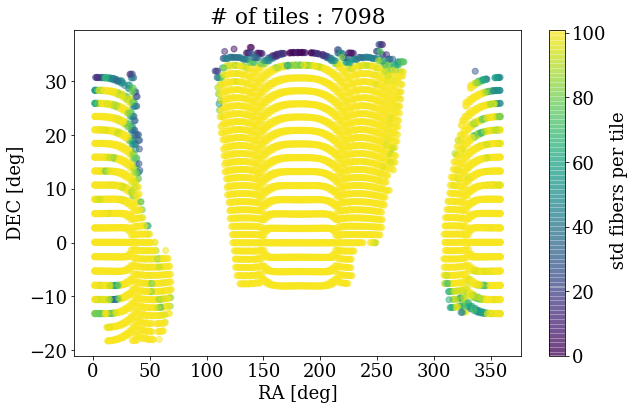

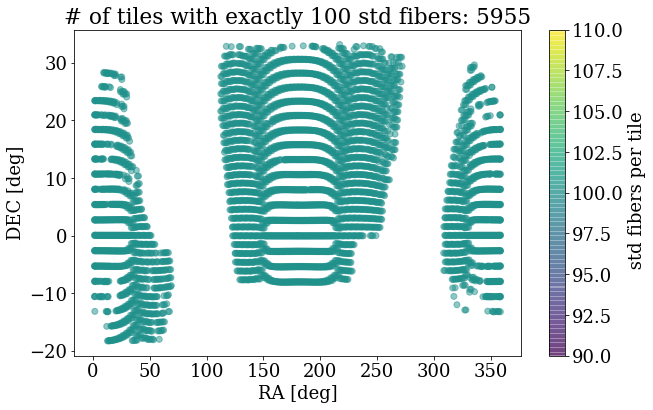

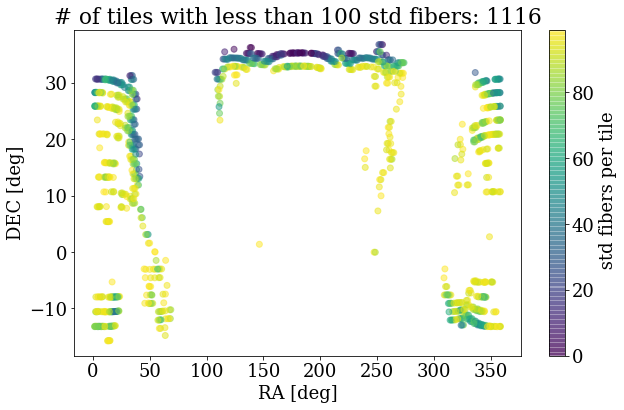

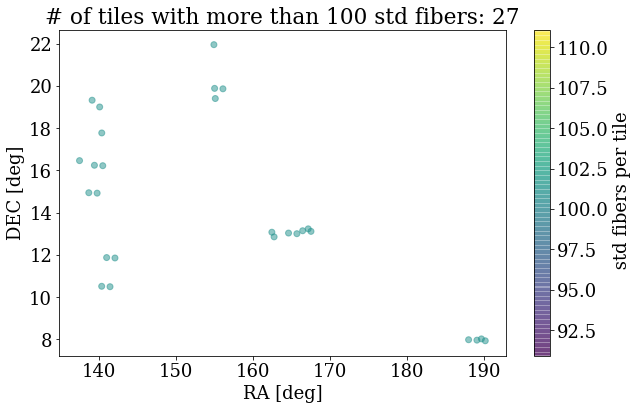

In [61]:
plot_footprint(counts, field='STD', limit=100, threshold='all')
plot_footprint(counts, field='STD', limit=100, threshold='exact')
plot_footprint(counts, field='STD', limit=100, threshold='below')
plot_footprint(counts, field='STD', limit=100, threshold='above')

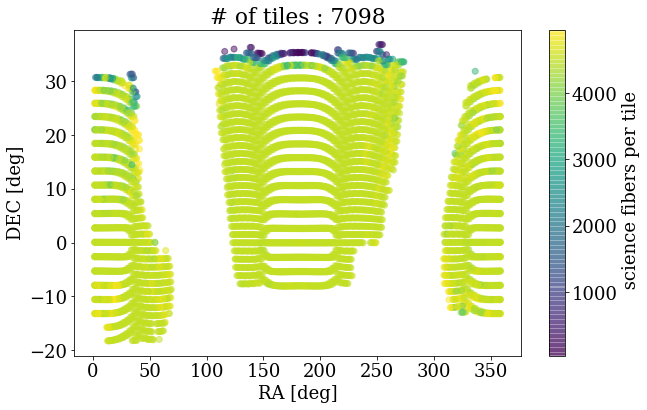

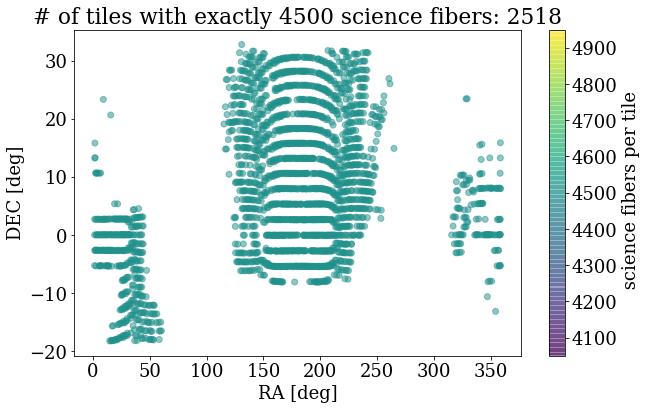

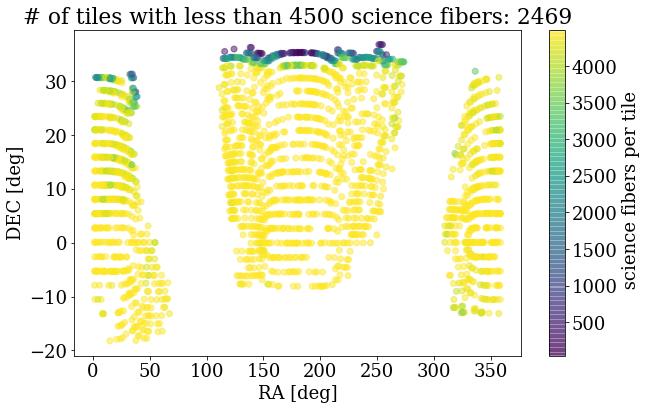

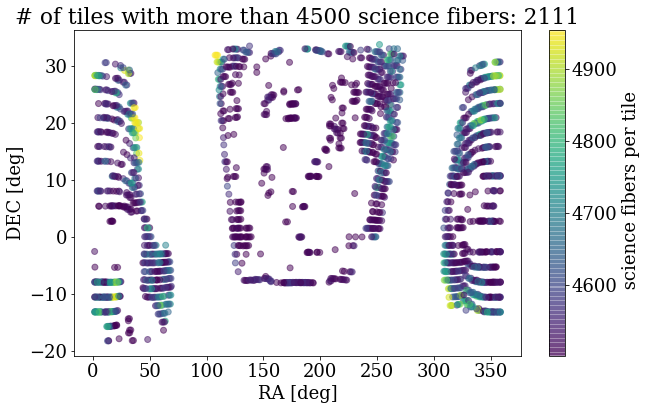

In [62]:
plot_footprint(counts, field='SCIENCE', limit=4500, threshold='all')
plot_footprint(counts, field='SCIENCE', limit=4500, threshold='exact')
plot_footprint(counts, field='SCIENCE', limit=4500, threshold='below')
plot_footprint(counts, field='SCIENCE', limit=4500, threshold='above')

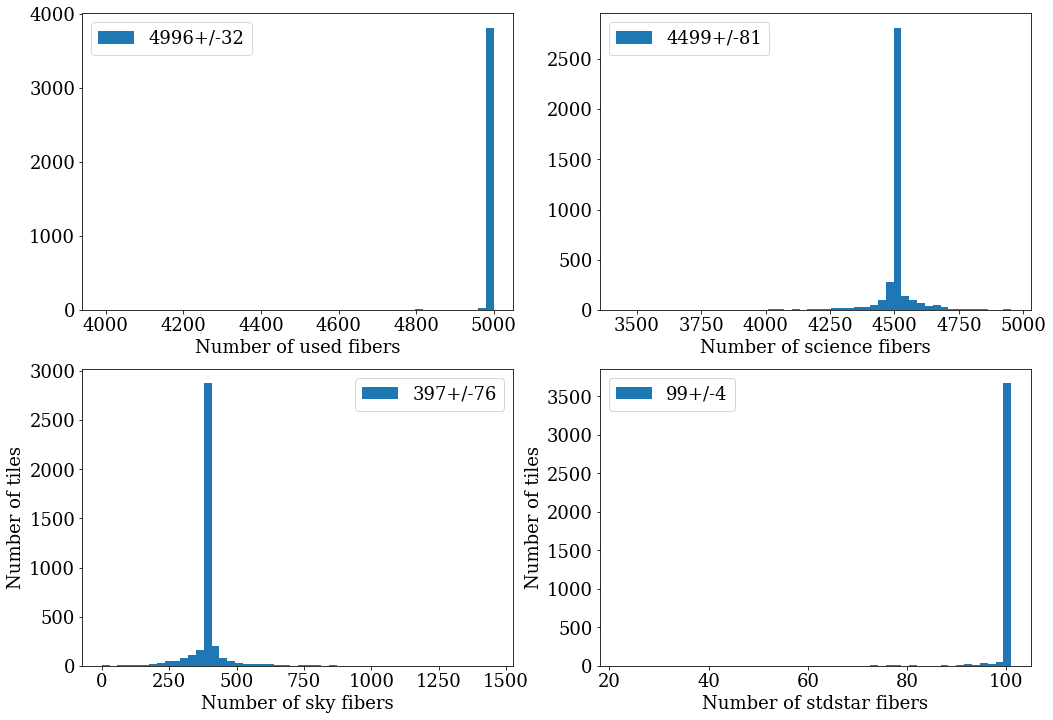

In [248]:
plt.figure(figsize=(17,12))

ii = (all_dec < 20) & (all_dec >-5)
all_used = all_science+all_sky+all_std
plt.subplot(2,2,1)
n = np.int(np.mean(all_used[ii]))
s = np.int(np.std(all_used[ii]))
_ = plt.hist(all_used[ii], bins=50, label='{}+/-{}'.format(n,s))
plt.xlabel('Number of used fibers')
plt.legend()


plt.subplot(2,2,2)
n = np.int(np.mean(all_science[ii]))
s = np.int(np.std(all_science[ii]))
_ = plt.hist(all_science[ii], bins=50, label='{}+/-{}'.format(n,s))
plt.xlabel('Number of science fibers')
plt.legend()



plt.subplot(2,2,3)
n = np.int(np.mean(all_sky[ii]))
s = np.int(np.std(all_sky[ii]))
_ = plt.hist(all_sky[ii], bins=50, label='{}+/-{}'.format(n,s))
plt.xlabel('Number of sky fibers')
plt.ylabel('Number of tiles')

plt.legend()


plt.subplot(2,2,4)
n = np.int(np.mean(all_std[ii]))
s = np.int(np.std(all_std[ii]))
_ = plt.hist(all_std[ii], bins=50, label='{}+/-{}'.format(n,s))
plt.xlabel('Number of stdstar fibers')
plt.ylabel('Number of tiles')

plt.legend()
plt.savefig('doc/used_fibers.pdf', bbox_inches='tight')

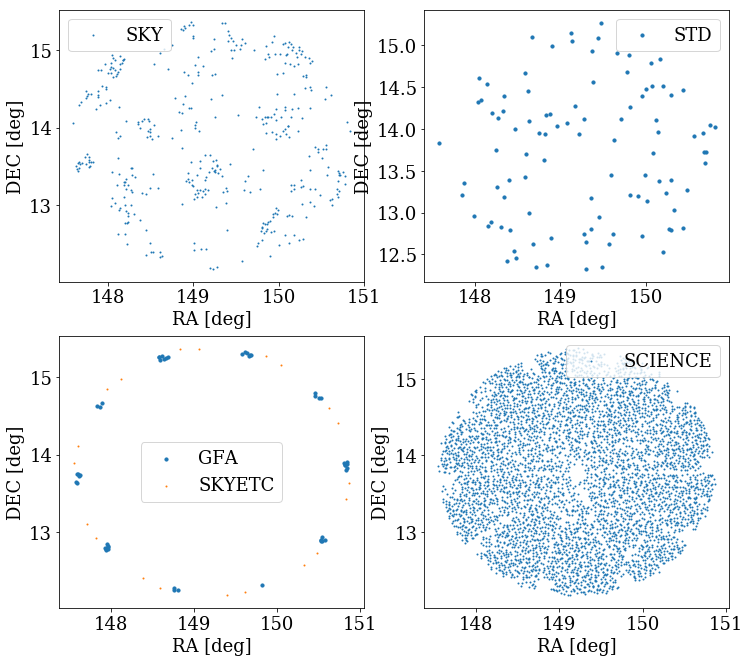

In [250]:
np.count_nonzero(ii)

3884

In [251]:
4996/5000.0

0.9992